# Model Parameter Initialization

Pytorch initializes the parameters by default, however, it is not always optimimal for certain cases. It also happens that even the default initialization leads to aberrant training loss.

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

## On layer

In [2]:
""" for a single layer using init
"""

linear = nn.Linear(5, 5)
nn.init.xavier_uniform_(linear.weight)

Parameter containing:
tensor([[-0.3153,  0.2290, -0.7257,  0.1230,  0.3987],
        [ 0.4264, -0.2578,  0.0789, -0.4058,  0.4034],
        [ 0.2900, -0.7498, -0.3052,  0.5333, -0.4576],
        [ 0.5835,  0.4658,  0.7589, -0.7386,  0.0936],
        [-0.2505,  0.5927,  0.7321, -0.3414,  0.4924]], requires_grad=True)

There are other methods of initialization provided by init module: https://pytorch.org/docs/master/nn.init.html. But not all initilization methods work for all type of layers/parameters.

In [3]:
# show that xavier initilization not working for bias
a = nn.Linear(5, 5)
# nn.init.xavier_uniform_(a.bias) # <- FAIL: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
print("dim of bias :", len(a.bias.data.shape), " is less than 2")

dim of bias : 1  is less than 2


In [4]:
""" for fixed value initialization using fill
"""

linear.weight.data.fill_(0.1) # for weight
linear.bias.data.fill_(0.1)

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000])

In [5]:
""" assign manually values
"""

linear = nn.Linear(5, 5)
linear.weight.data = torch.ones((5,5))
print("wieghts: ", linear.weight.data)
linear.bias.data = torch.ones((5))
print("bias: ", linear.bias.data)

wieghts:  tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
bias:  tensor([1., 1., 1., 1., 1.])


## On layer wrappers

In [6]:
""" for certain layers in a sequence
"""

def init_layer(l) :
    if isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
        l.bias.data.fill_(0.1)

seq = nn.Sequential(
    nn.Linear(5, 5),
    nn.Linear(5, 5)
)
seq.apply(init_layer)

ml = nn.ModuleList([nn.Linear(5, 5), nn.Linear(5, 5)])
ml.apply(init_layer)

ModuleList(
  (0-1): 2 x Linear(in_features=5, out_features=5, bias=True)
)

## For all parameters in model

'apply' doesn't work strutures other than sequential ones. So for a general model, we need other ways to do the initialization.

### On parameters

This method is to initilize the parameters. So it doesn't work for method which requires higher dimensions.

In [7]:
""" initialize by parameters
"""

def init_params(m, func, *params, **kwargs) :
    for p in m.parameters() :
        func(p, *params, **kwargs)

model = models.resnet18()
init_params(model, nn.init.normal_, mean=0, std=1) # normal distribution - OK
init_params(model, nn.init.constant_, 1.) # constant value - OK
# init_params(model, nn.init.xavier_normal_, 1.) # xavier - FAIL

### On selected layers

This method is to initilize the selected layers.

In [8]:
""" initialize by layer
"""

def init_weights(model):
    for m in model.modules():
        if type(m) in (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d, nn.Linear):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

init_weights(model)

### Constant

Using constant values.

In [9]:
""" using fixed values
"""

def init_fixed(model) :
    for p in model.parameters() :
        p.data.fill_(0.1)

init_fixed(model)

### Put all together

To combine all previous method together and to initialize models of all possible types of layers, we can filter layers and apply initialization accordingly.

In [10]:
""" apply initilization by the param shape
"""
#3.10
def init_model(model):
    for p in model.parameters():
        match len(p.shape):
            case 1: 
                torch.nn.init.normal_(p, mean=0., std=1.), # dime=1 like bias
            case 2: 
                torch.nn.init.xavier_normal_(p, gain=1.), # dim=2 like linear
            case 3: 
                torch.nn.init.xavier_uniform_(p, gain=1.), # dim=3 like Conv1d
            case 4: 
                torch.nn.init.xavier_uniform_(p, gain=1.), # dim=4 like Conv2d
            case 5: 
                torch.nn.init.xavier_uniform_(p, gain=1.), # dim=5 like Conv3d
            case _: 
                torch.nn.init.constant(p, 1.), # else

init_model(model)

### Some other ways

Normally, the weights in a neural network should be set around zero. Some common practice is to start the weights in the range of $[-\frac{1}{\sqrt{n}}, \frac{1}{\sqrt{n}}]$ where n is the number of inputs.

In [11]:
""" apply specific value rule
"""

def weights_init_uniform_rule(m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1 :
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)

weights_init_uniform_rule(model)

# Illustration of initialization

From my experience, I had problem to replicate training results in some cases and I realized initialization was responsible. Even pytorch initiliza the parameters by default, but it is not always optimal. 

In [12]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as utils
data_transforms = [
    transforms.ToTensor(), # convert to the range [0,1]
]
data_transforms = transforms.Compose(data_transforms)
data = datasets.MNIST("./mnist", download=False, transform=data_transforms)
batch_size = 100

# dataloaders
train_loader = utils.DataLoader(dataset=data, batch_size=batch_size)
valid_loader = utils.DataLoader(dataset=data, batch_size=batch_size)

In [13]:
model = nn.Sequential(
    nn.Linear(28*28, 1024),
    nn.ReLU(),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1)
)

def train(epochs, model, loss, optim, init, loader) :

    init(model)
    loss_log = []

    for e in range(epochs) :

        loss_tot = 0
        loss_num = 0
    
        for data, label in loader:
            data = data.view(100, -1)
            preds = model(data)
            l = loss(preds, label)

            loss_num += len(data)
            loss_tot += l * len(data)
            
            optim.zero_grad()
            l.backward()
            optim.step()
        # print("{} / {} : loss: {} ".format(e+1, epochs, loss_tot/loss_num))
        loss_log.append((loss_tot/loss_num).detach().numpy())

    return loss_log       

In [14]:
import torch
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
init_fixed = init_fixed
loss_log_constant = train(50, model, loss_fn, optimizer, init_fixed, valid_loader)
init_uniformrule = weights_init_uniform_rule
loss_log_uniformrule = train(50, model, loss_fn, optimizer, init_uniformrule, valid_loader)
init_uniXavier = init_model
loss_log_xavier = train(50, model, loss_fn, optimizer, init_uniXavier, valid_loader)

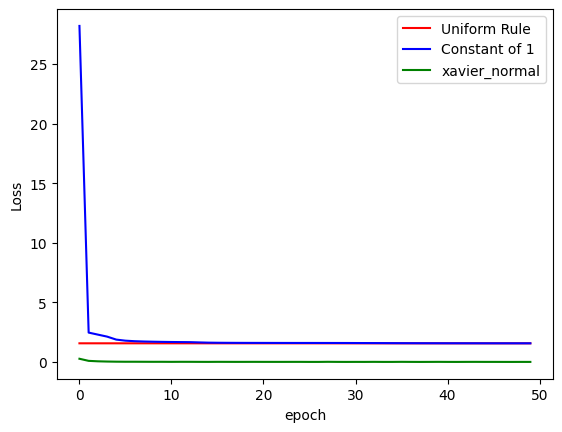

In [19]:
import matplotlib.pyplot as plt
ep = [i for i in range(len(loss_log_uniformrule))]
plt.plot(ep, loss_log_uniformrule, 'r', label='Uniform Rule')
plt.plot(ep, loss_log_constant, 'b', label='Constant of 0.1')
plt.plot(ep, loss_log_xavier, 'g', label='xavier_normal')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

The example is meaningless, however, it shows that the paremeter initialization can impact greatly the training process, or even the final results (the loss can explode).